# Day 1 — Netflix Data Cleaning
Dataset: Netflix Movies and TV Shows (Kaggle)
Goal: clean and normalize fields for downstream use

In [1]:
# Cell 1: imports and quick checks
import os
import re
from pprint import pprint
import pandas as pd
import numpy as np

print("pandas", pd.__version__)
print("numpy", np.__version__)

RAW = "data/raw/netflix_titles.csv"
PROC = "data/processed/netflix_clean.csv"

# show file exists
print("raw file exists:", os.path.exists(RAW))


pandas 2.3.2
numpy 2.3.3
raw file exists: True


In [2]:
# Cell 2: load and peek
df = pd.read_csv(RAW)
print("rows, cols:", df.shape)
df.head(8)

rows, cols: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."


In [3]:
# Cell 3: data info and missing counts
df.info()
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


director      2634
country        831
cast           825
date_added      10
rating           4
duration         3
dtype: int64

In [4]:
# Cell 4: normalize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.columns.tolist()

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [5]:
# Cell 5: drop duplicates by all columns or by show_id
initial_row = len(df)
df = df.drop_duplicates()
print("dropped duplicate rows: ", initial_row - len(df))

# make sure show_id is unique; if not, choose logic
print("Unique show_id count:", df['show_id'].unique())

dropped duplicate rows:  0
Unique show_id count: ['s1' 's2' 's3' ... 's8805' 's8806' 's8807']


In [6]:
# Cell 6: strip whitespace and collapse repeated spaces for text columns

text_cols = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'listed_in', 'description']
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan':None, 'None': None})
        df[c] = df[c].replace('nan', None)
           

In [7]:
# Cell 7: parse date_added; many formats exist like 'September 9, 2019' or NaN

if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Create a fallback: if date_added is NaT, maybe set it from release_year:
if 'release_year' in df.columns:
    missing_dates = df['date_added'].isna().sum()
    print("missing date_added before fallback:", missing_dates)
    
    # where date_added is NaT, set to Jan 1 of release_year (best-effort)
    df.loc[df['date_added'].isna() & df['release_year'].notna(), 'date_added'] = \
        pd.to_datetime(df.loc[df['date_added'].isna() & df['release_year'].notna(), 'release_year'].astype(int).astype(str) + "-01-01")
    print("missing date_added after fallback:", df['date_added'].isna().sum())

missing date_added before fallback: 98
missing date_added after fallback: 0


In [8]:
# Cell 8: split columns that contain comma-separated lists into lists

def split_to_list(x):
    if pd.isna(x) or x is None:
        return []
    # sometimes fields are single string; split on comma and strip
    return [item.strip() for item in str(x).split(',') if item.strip()]

for col in ['cast', 'country', 'listed_in']:
    if col in df.columns:
        df[col + '_list'] = df[col].apply(split_to_list)

In [9]:
# Cell 9: parse duration to numeric + unit (minutes vs seasons)

def parse_duration(d):
    if pd.isna(d) or d is None:
        return (np.nan, None)
    
    # examples: '90 min', '1 Season', '2 Seasons'
    s = str(d).strip()
    
    # minutes
    m = re.search(r'(\d+)\s*min', s)
    if m:
        return (int(m.group(1)), 'min')
    
    s2 = re.search(r'(\d+)\s*Season', s)
    if s2:
        return (int(s2.group(1)), 'season')
    # fallback numeric extraction
    m2 = re.search(r'(\d+)', s)
    if m2:
        return (int(m2.group(1)), None)
    return (np.nan, None)
    

df[['duration_int', 'duration_type']] = df['duration'].apply(lambda x: pd.Series(parse_duration(x)))

In [10]:
# Cell 10: normalize rating categories into simpler buckets

def normalize_rating(r):
    if pd.isna(r) or r is None or r == 'nan':
        return 'Unknown'
    s = str(r).upper().strip()
    # a simple mapping: kids/family/adult/unknown
    kids = {'G','TV-Y','TV-Y7'}
    family = {'PG','PG-13','TV-G','TV-PG'}
    adult = {'R','NC-17','TV-MA','MA15+'}
    if any(s.startswith(k) for k in kids):
        return 'Kids'
    if any(s.startswith(k) for k in family):
        return 'Family'
    if any(s.startswith(k) for k in adult):
        return 'Adult'
    return s  # keep original if unknown

if 'rating' in df.columns:
    df['rating_simple'] = df['rating'].apply(normalize_rating)

In [11]:
# Cell 11: director and cast - fill missing

if 'director' in df.columns:
    df['director'] = df['director'].replace({None: np.nan})
    df['director'] = df['director'].fillna("Unknown")

# cast_list created earlier; create a 'primary_actor' for quick filters
if 'cast_list' in df.columns:
    df['primary_cast'] = df['cast_list'].apply(lambda x: x[0] if x else "Unknown")


In [12]:
# Cell 12: explode listed_in_list to get top genres
from collections import Counter
all_genres = Counter()
if 'listed_in_list' in df.columns:
    df['listed_in_list'].apply(lambda lst: all_genres.update(lst))
top_genres = [g for g,_ in all_genres.most_common(10)]
print("top genres:", top_genres)

# create binary columns for top genres
for g in top_genres:
    safe_name = g.lower().replace(' ','_')
    df[f'genre_{safe_name}'] = df['listed_in_list'].apply(lambda lst: int(g in lst))

top genres: ['International Movies', 'Dramas', 'Comedies', 'International TV Shows', 'Documentaries', 'Action & Adventure', 'TV Dramas', 'Independent Movies', 'Children & Family Movies', 'Romantic Movies']


In [13]:
# Cell 13: final checks
print("shape after cleaning", df.shape)
print("missing per column after cleaning (sample):")
print(df[['title','show_id','type','date_added','duration_int','duration_type','rating_simple']].isnull().sum())
# ensure essential columns have no nulls:
assert df['show_id'].notna().all(), "show_id has nulls!"
assert df['title'].notna().all(), "title has nulls!"


shape after cleaning (8807, 29)
missing per column after cleaning (sample):
title            0
show_id          0
type             0
date_added       0
duration_int     3
duration_type    3
rating_simple    0
dtype: int64


In [14]:
# Cell 14: save processed file
os.makedirs("data/processed", exist_ok=True)
df.to_csv(PROC, index=False)
print("saved cleaned csv to", PROC)


saved cleaned csv to data/processed/netflix_clean.csv


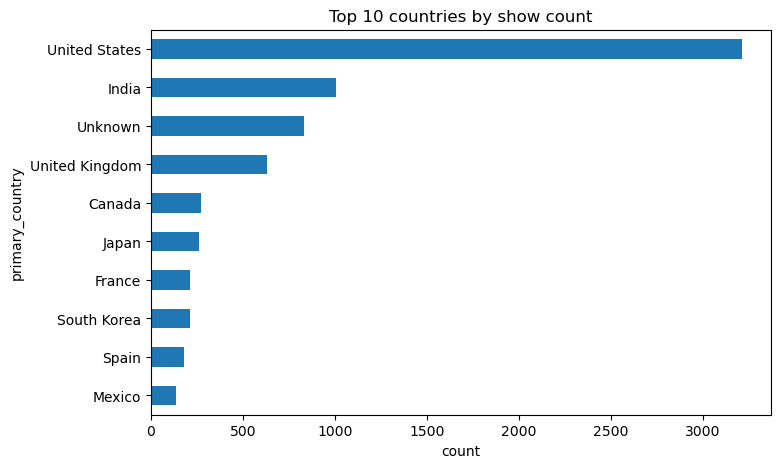

In [15]:
# Cell 15: quick EDA plots (run in notebook)
import matplotlib.pyplot as plt

# top 10 countries by show count (take first country if multiple)
df['primary_country'] = df['country_list'].apply(lambda lst: lst[0] if lst else "Unknown")
top_countries = df['primary_country'].value_counts().nlargest(10)
top_countries.plot(kind='barh', figsize=(8,5))
plt.title("Top 10 countries by show count")
plt.xlabel("count")
plt.gca().invert_yaxis()
plt.show()
